---

# 9 Advanced deep learning for computer vision

## 9.1 Three essential computer vision tasks

In [9]:
import os
import sys
import random
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

- *Image classification*: assign one or more labels to an images;
- *Image segmentation*: partition image into different areas (locating categories of bojects), operates on **pixels**;
- *Object detection*: draw rectangles around object.

<!-- ![Chollet three tasks](images/chollet.three-tasks.png) -->
![Chollet three tasks](https://github.com/jchwenger/AI/blob/main/5-additional-material/images/chollet.three-tasks.png?raw=true)

---

## 9.2 An image segmentation example

[Oxford pets reference page](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [10]:
repo_dir = pathlib.Path("oxford-pets")
if not os.path.exists(repo_dir):
    !git clone https://github.com/ml4py/dataset-iiit-pet oxford-pets/dataset-iiit-pet

In [8]:
!ls oxford-pets

dataset-iiit-pet


In [11]:
batch_size = 64
img_size = (200, 200)

base_dir = repo_dir / "dataset-iiit-pet"
input_dir = base_dir / "images/"
target_dir = base_dir / "annotations/trimaps/"

In [15]:
input_img_paths = sorted(
    [
        str(path) for path in input_dir.glob("*.jpg")
    ]
)

target_paths = sorted(
    [
        str(path)
        for path in target_dir.glob("*.png")
        if not path.name.startswith(".")
    ]
)

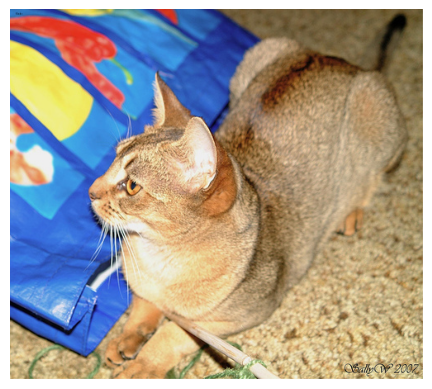

In [16]:
plt.axis("off")
plt.imshow(tf.keras.utils.load_img(input_img_paths[9]))

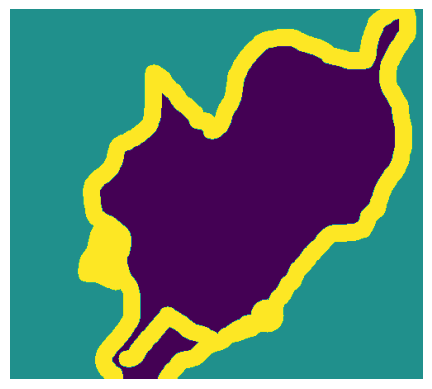

In [17]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = tf.keras.utils.img_to_array(tf.keras.utils.load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [20]:
input_fname_ds = tf.data.Dataset.list_files(f"{input_dir}/*.jpg", shuffle=False)
target_fname_ds = tf.data.Dataset.list_files(f"{target_dir}/*.png", shuffle=False).filter(
    lambda x : not tf.strings.regex_full_match(x, ".*\/\..*")) # remove files starting with .

main_fname_ds = tf.data.Dataset.zip(
    (input_fname_ds, target_fname_ds)
)

In [21]:
# sanity check, all file names are equal to their targets
sanity = True
if not sanity:
    for f,g in main_fname_ds:
        fstr = f.numpy().decode()
        gstr = g.numpy().decode()
        fs = fstr[fstr.rfind("/"):-3]
        gs = gstr[gstr.rfind("/"):-3]
        if fs != gs:
            print(fs)
            print(gs)

In [22]:
def parse_image(fname):
    """Source: https://www.tensorflow.org/guide/data#decoding_image_data_and_resizing_it"""
    img = tf.io.read_file(fname)
    img = tf.io.decode_jpeg(
        img, channels=3, try_recover_truncated = True,
        acceptable_fraction=1,
    )
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_size)
    return img

def parse_target(fname):
    img = tf.io.read_file(fname)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.resize(img, img_size)
    return img - 1

def map_func(x, y):
    return parse_image(x), parse_target(y) # , x, y

processed_ds = main_fname_ds.map(map_func)

In [23]:
# check image and mask
sanity = True
if not sanity:
    for i,t in processed_ds.skip(10):
        print(i.shape)
        print(t.shape)
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(i)
        ax[1].imshow(t * 127)
        break

In [24]:
# shuffle before you batch https://stackoverflow.com/a/50453698
# prefetch: https://stackoverflow.com/questions/63796936/what-is-the-proper-use-of-tensorflow-dataset-prefetch-and-cache-options
# complete tutorial: https://www.tensorflow.org/guide/data_performance
# also: https://cs230.stanford.edu/blog/datapipeline/#best-practices
val_steps = 16

                           # ↓ from 1024 onward
train_dataset = processed_ds.skip(batch_size * val_steps)\
                    .shuffle(batch_size * val_steps)\
                    .batch(batch_size, drop_remainder=True)\
                    .prefetch(tf.data.AUTOTUNE)\
                    .repeat()

                         # ↓ the first 1024
val_dataset = processed_ds.take(batch_size * val_steps)\
                    .shuffle(batch_size * val_steps)\
                    .batch(batch_size, drop_remainder=True)\
                    .prefetch(tf.data.AUTOTUNE)\
                    .repeat()

In [25]:
sanity = True
ds = train_dataset # val_dataset
if not sanity:
    for i,t in ds.skip(6):
        print(i.shape)
        print(t.shape)

        fig, ax = plt.subplots(1,2)
        ax[0].imshow(i[0].numpy())
        normalized_array = t[0] * 127
        ax[1].imshow(normalized_array[:, :, 0])
        break

<!-- ![Kaveh, stack overflow](images/deconv/deconv.1.png) -->
![Kaveh, stack overflow](https://github.com/jchwenger/AI/blob/main/5-additional-material/images/deconv/deconv.1.png?raw=true)

<small>Source: [Kaveh's answer to "In Keras what is the difference between Conv2DTranspose and Conv2D", stack overflow](https://stackoverflow.com/a/68980531)</small>

<!-- ![Kaveh, stack overflow](images/deconv/deconv.2.png) -->
![Kaveh, stack overflow](https://github.com/jchwenger/AI/blob/main/5-additional-material/images/deconv/deconv.2.png?raw=true)


<small>Source: [Kaveh's answer to "In Keras what is the difference between Conv2DTranspose and Conv2D", stack overflow](https://stackoverflow.com/a/68980531)</small>

In [27]:
                                   # ↓ backward compatibility with Chollet's code down below
def get_model(img_size, num_classes, tf_dataset=True):
    inputs = tf.keras.Input(shape=img_size + (3,))
    if not tf_dataset:                        # in Chollet's original setup the rescaling happens here, whereas
        x = tf.keras.tf.keras.layers.Rescaling(1./255)(inputs)  # tf.image.convert_image_dtype does that for us in the pipeline
    else:
        x = inputs

    # shrink input (like an encoder)
    x = tf.keras.layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    # unshrink input (like a decoder)
    x = tf.keras.layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = tf.keras.layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = tf.keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = tf.keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 50, 50, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 100, 100, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 100, 100, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 200, 200, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 200, 200, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy"
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(base_dir, "oxford_segmentation.keras"),
        save_best_only=True
    )
]

# to revert back to Chollet's version, follow the comments
history = model.fit(
    train_dataset, # Chollet: train_input_imgs, train_targets,
    epochs=50,
    steps_per_epoch=(len(input_img_paths) - batch_size * 16)//batch_size, # Not in Chollet! (our tf.dataset is infinite, we must give the number of steps)
    batch_size=batch_size,
    validation_data=val_dataset, #  Chollet: validation_data=(val_input_imgs, val_targets)
    validation_steps=val_steps, # Not in Chollet (infinite tf.dataset, we provide the steps ourselves)
    callbacks=callbacks,
)

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 124s 706ms/step - loss: 0.9661 - val_loss: 0.9298
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 58s 582ms/step - loss: 0.8943 - val_loss: 0.8769
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 62s 574ms/step - loss: 0.8481 - val_loss: 0.8198
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 61s 572ms/step - loss: 0.8060 - val_loss: 0.7896
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 58s 565ms/step - loss: 0.7872 - val_loss: 0.7981
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 57s 578ms/step - loss: 0.7713 - val_loss: 0.7729
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 57s 573ms/step - loss: 0.7470 - val_loss: 0.7393
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 56s 568ms/step - loss: 0.7399 - val_loss: 0.7674
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 57s 581ms/step - loss: 0.7178 - val_loss: 0.6970
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 57s 575ms/step - loss: 0.7036 - val_loss: 0.6945
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 57s 576ms/step - loss: 0.6659 - val_loss: 0.6626
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5

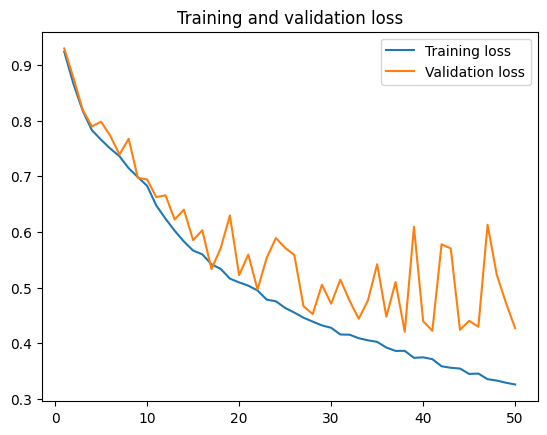

In [29]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [30]:
def display_mask(model, i):

    # get image
    # test_image = val_input_imgs[i]             # change to this line in Chollet's original setup
    for img, tgt in val_dataset.skip(i).take(1):
        test_image = img[0]

    # get mask
    pred = model.predict(np.expand_dims(test_image, 0), verbose=0)[0]
    mask = np.argmax(pred, axis=-1)
    mask *= 127

    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.axis("off")
    ax1.imshow(tf.keras.utils.array_to_img(test_image))
    ax2.axis("off")
    ax2.imshow(mask)
    plt.show()

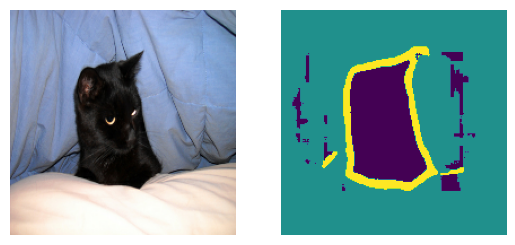

In [31]:
i = 10
display_mask(model, i)

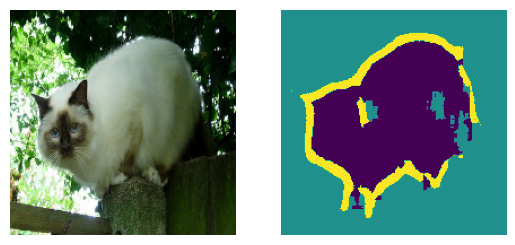

In [32]:
i = 1
display_mask(model, i)

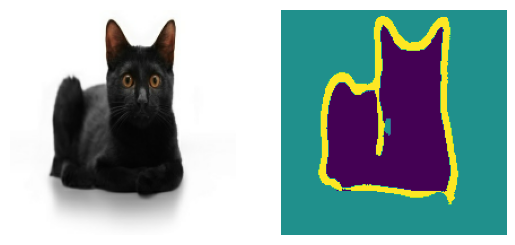

In [33]:
i = 4
display_mask(model, i)

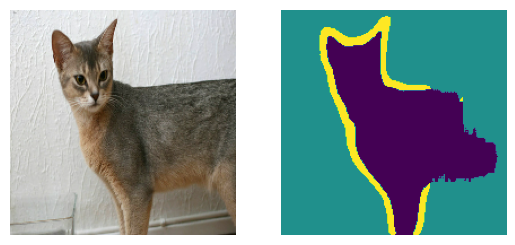

In [34]:
reloaded_model = tf.keras.models.load_model(os.path.join(base_dir, "oxford_segmentation.keras"))
i = 4
display_mask(reloaded_model, i)